In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh, expm, svd
import quimb as qu
from scipy.optimize import curve_fit
from scipy import stats
import warnings
import time
import seaborn as sns

# warnings.filterwarnings("ignore")

/home/kia/Desktop/PoD/myenv/lib/python3.12/site-packages/cotengra/hyperoptimizers/hyper.py:54: UserWarning: Couldn't find `optuna`, `cmaes`, or `nevergrad` so will use completely random sampling in place of hyper-optimization.
  warnings.warn(
/home/kia/Desktop/PoD/myenv/lib/python3.12/site-packages/cotengra/hyperoptimizers/hyper.py:36: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn(
/home/kia/Desktop/PoD/myenv/lib/python3.12/site-packages/cotengra/hyperoptimizers/hyper.py:73: UserWarning: Couldn't find `optuna`, `cmaes`, or `nevergrad` so will use completely random sampling in place of hyper-optimization.
  warnings.warn(


Steps of the algorithm:

1. INITIALIZATION: Start from a normalized random MPS with shape (1, d, chi) (chi, d, chi) (chi, d, 1)
    The Spin operators are also constructed and saved 

    
    
2. EVOLVE METHOD: $$\\$$
    requires the methods: $\\$
              time_evolution_operator-> We need the Hamiltonian 
              since the time evolution operator is $$U(t)=\exp(-iHt)$$
              
     which start initializing the Hamiltonian and if it is already initialize just takes it. Then it computes the time evolution operator   
     
    trotterize -> Since the Hamiltonian is an operator and is inside the time evolution operator which is an exponent we make use of the Trotter-Suzuki decomposition which approximates the exponent of a sum of operators with a product of exponents of the same operators, using the second order decomposition:
      $$e^{(V+W)\delta}=e^{V\delta/2}e^{W\delta}e^{V\delta/2}+\mathcal{O}(\delta^3)$$
      So the trotterize method applies the previous to each bond via the UPDATE method
      
         requires: UPDATE method.
                 At each bond this method has the MPS matrix for A and the next bond being B.
                 Then A and B are contracted together and then contracted with U operator (Time evolution operator)
                 The SVD is applied to the resulting matrix
                 
                 Then we do the truncation, here we are only keeping the largests singular values
                 
                 Then we reconstruct the tensor A and B as A_new and B_new and replace the old A and B with the new ones
                 
    The EVOLVE method applies the time evolution operator at each step via the trotterize method which also modifies the MPS at each step evolving it.
    
Note: The random MPS initially is normalized but not in left/right canonical form, along the evolution canonicality can be enforced if make_canonical_every>0. In the implementation we set it =1 so every step we canonicalize by calling the get_norm method which in mode = 'sweep_first' left normalizes all tensors and enforces left-canonical form ($A^\dagger A=I$) 


After those steps we are able to find some physical quantities such as total energy, entropy and correlation lenght via the methods:

Total_energy -> On each bond the expectation value is found and sum over the whole chain

Entropy -> The Von Neumann Entropy is found by using the already evolved final MPS and then to that applying SVD to find the singular values, then the entropy is found per each bond using the formula $$S=-\sum_i\lambda^2_i\log(\lambda^2_i)$$ where $\lambda_i$ are the singular values from the SVD

full_chain_correlation_lenght -> For each matrix of the MPS of the chain we compute the transfer matrix as $T=\sum_i A_i\cdot \bar{A}_i$, then we diagonalize T and find the two biggest eigenvalues $\lambda_1, \;\lambda_2$ and then find the correlation lenght as $=-\frac{1}{\log\frac{\lambda_2}{\lambda_1}}$

Correlation length -> 
    
    1. Using transfer matrix
    
    2. Using correlation function
    
Energy convergence as function of the timesteps for several time intervals (dt)

Timing plots

         
     
         

In [2]:
class TNet():



    def __init__(self, N, spin=1, chi=2, max_bond_dim=20):

        """
        Initialize the TNet class. Manages the Matrix Product States for the AKLT model.

        Args:
            N (int): Number of sites in the chain.
            spin (int): Spin of each site (default: 1).
            chi (int): Maximum bond dimension (default: 2).
            max_bond_dim (int): Maximum bond dimension (default: 20).
        """


        if N < 2:
            raise ValueError("N must be at least 2.")

        if spin < 0:
            raise ValueError("spin must be non-negative.")

        if chi < 1:
            raise ValueError("chi must be at least 1.")

        if max_bond_dim < 1:
            raise ValueError("max_bond_dim must be at least 1.")
        
        if max_bond_dim < chi:
            raise ValueError("max_bond_dim must be at least chi.")
        
        

        self.N = N
        self.spin = spin
        self.d = int(2 * self.spin + 1)
        self.chi = chi
        self.max_bond_dim = max_bond_dim
        self.norm = None
        self.singvals = [None] * (self.N-1)
        
        """We are starting from a random MPS with open boundary conditions.
        The first and last tensors have shapes (1, d, chi) and (chi, d, 1) respectively,
        ensuring scalar contraction at the ends. The internal tensors will have shape (chi, d, chi)."""

        L = np.random.randn(1, self.d, self.chi) + 1j * np.random.randn(1, self.d, self.chi)
        R = np.random.randn(self.chi, self.d, 1) + 1j * np.random.randn(self.chi, self.d, 1)
        L /= np.linalg.norm(L)/np.sqrt(self.chi)
        R /= np.linalg.norm(R)

        self.MPS = []
        self.MPS.append(L)
        
        """Internal tensors"""
        for _ in range(N-2):
            randomized_site = np.random.randn(self.chi, self.d, self.chi) + 1j * np.random.randn(self.chi, self.d, self.chi)
            randomized_site /= np.linalg.norm(randomized_site)/np.sqrt(self.chi)
            self.MPS.append(randomized_site)
        self.MPS.append(R)
        self.get_norm()
        
        self.H = None
        self.U = None
        self.Sx, self.Sy, self.Sz = self.spin_ops()
        self.CHIs = self.chi*np.ones(self.N-1, dtype=int)
        
        
    def spin_ops(self):
        
        Sx = qu.spin_operator('x', self.spin)
        Sy = qu.spin_operator('y', self.spin)
        Sz = qu.spin_operator('z', self.spin)

        return Sx, Sy, Sz
    
    @staticmethod
    def get_truncation_index(singular_values, threshold = 1e-4):

        threshold = 1 - threshold
        arr = singular_values.copy()
        arr = np.sort(arr)[::-1]
        index = np.argmax(arr.cumsum()>threshold)+1

        return index
    
    def aklt_2site_hamiltonian(self):
        """We are defining the Hamiltonian wich is translational
         invariant so we only need a cell to compute the evolution operator.
        """

        Sx, Sy, Sz = self.Sx, self.Sy, self.Sz
        
        SdotS = (
        np.einsum('ij,kl->ikjl', Sx, Sx) +
        np.einsum('ij,kl->ikjl', Sy, Sy) +
        np.einsum('ij,kl->ikjl', Sz, Sz)
        )

        SdotS = SdotS.reshape(self.d**2, self.d**2)

        H = SdotS + 1/3 * SdotS@SdotS

        return H



    def make_left_canonical(self, bond=0, mode = 'qr', verbose=False):
        """We are starting from a random MPS, which is not usually in canonical form.
        Putting tensors into canonical form makes them act as isometries, which is 
        crucial for numerical stability and efficient truncation during TEBD.

        Args:
            bond (int): The bond index to be made left-canonical. Default is 0.
            mode (str): The method used to make the bond left-canonical. Default is 'qr'.
            verbose (bool): Whether to print a warning message if the bond dimension changes. Default is False.
        """
        

        if bond < 0 or bond >= self.N - 1:
            raise ValueError(f"Bond index {bond} out of range. Must be between 0 and {self.N - 2}(inclusive).")
        
        A = self.MPS[bond]
        B = self.MPS[bond + 1]
        chiL, d, chiB = A.shape
        _, _, chiR = B.shape

        if mode == 'qr':
            
            Q, R = np.linalg.qr(A.reshape(chiL * d, chiB), mode='reduced')
            chi_new = R.shape[0]

            A_new = Q.reshape(chiL, d, chi_new)
            B_new = np.einsum('ij,jkl->ikl', R, B).reshape(chi_new, d, chiR)
            self.MPS[bond] = A_new
            self.MPS[bond + 1] = B_new
            
            if self.CHIs[bond] != chi_new:
                if verbose:
                    message = f"bond dimension {bond} changed from {self.CHIs[bond]} to {chi_new}."
                    warnings.warn(message, UserWarning)
                self.CHIs[bond] = chi_new

        elif mode == 'svd':
            
            u, s, vh = svd(A.reshape(chiL * d, chiB), full_matrices=False)
            index = TNet.get_truncation_index(s)
            chi_new = min(self.max_bond_dim, index)
            chi_new = max(2, chi_new)
            if chi_new < len(s):
                discarded_weight = np.sum(s[chi_new:]**2)/np.sum(s**2)
                message = f"Truncating bond dimension at bond {bond} to {chi_new} from {len(s)}. \nDiscarded weight: {discarded_weight:.4f}.\nIncrease max_bond_dim if needed."
                warnings.warn(message, UserWarning)

            u = u[:, :chi_new]
            s = s[:chi_new]
            vh = vh[:chi_new, :]

            svh = np.diag(s) @ vh

            A_new = u.reshape(chiL, d, chi_new)
            B_new = np.einsum('ij,jkl->ikl', svh, B).reshape(chi_new, d, chiR)
            self.MPS[bond] = A_new
            self.MPS[bond + 1] = B_new

            self.singvals[bond] = s

            if self.CHIs[bond] != chi_new:
                if verbose:
                    message = f"bond {bond} changed from {self.CHIs[bond]} to {chi_new}."
                    warnings.warn(message, UserWarning)
                self.CHIs[bond] = chi_new

        else:
            raise ValueError(f"Unknown mode '{mode}'. Use 'qr' or 'svd'.")



    def is_left_canonical(self, site=0, all=False):
            """Check the isometry: A† A = I"""
            
            if all:
                left_can_list = [self.is_left_canonical(s, all=False) for s in range(self.N-1)]
                return left_can_list

            A = self.MPS[site]
            chiL, d, chiR = A.shape
            A = A.reshape(chiL * d, chiR)

            mat = A.T.conj()@A
            identity = np.eye(len(mat))

            return np.allclose(mat, identity)



    def sweep_right(self, start = 0, end=None, mode='qr'):
        """Sweep the MPS to the right, making each tensor left-canonical.
        Args:
            start (int): Starting bond index for the sweep. If None, starts from the first bond.
            end (int): Ending bond index for the sweep. If None, sweeps to the last bond.
            mode (str): 'qr' or 'svd'. Determines the method of making tensors left-canonical.
        """
        
        if end is None:
            end = self.N - 1

        for bond in range(start, end):
            self.make_left_canonical(bond, mode=mode, verbose=False)



    def make_right_canonical(self, bond=None, mode='qr', verbose=False):
        """Make the MPS right-canonical at a given bond.
        Args:
            bond (int): Index of the bond to make right-canonical. If None, defaults to the last bond.
            mode (str): 'qr' or 'svd'. Determines the method of making tensors right-canonical.
            verbose (bool): If True, prints warnings when bond dimensions change.
        """

        if bond is None:
            bond = self.N - 2

        if bond < 0 or bond >= self.N - 1:
            raise ValueError(f"Bond index {bond} out of range. Must be between 0 and {self.N - 2}(inclusive).")

        A = self.MPS[bond]
        B = self.MPS[bond + 1]
        chiL, d, chiB = A.shape
        _, _, chiR = B.shape

        if mode == 'qr':
            B_reshaped = B.reshape(chiB, d * chiR).T
            Q, R = np.linalg.qr(B_reshaped, mode='reduced')

            chi_new = Q.shape[1]
            B_new = Q.T.reshape(chi_new, d, chiR)
            A_new = np.einsum('aib,bc->aic', A, R.T).reshape(chiL, d, chi_new)

            self.MPS[bond] = A_new
            self.MPS[bond + 1] = B_new

            if self.CHIs[bond] != chi_new:
                if verbose:
                    message = f"bond dimension {bond} changed from {self.CHIs[bond]} to {chi_new}."
                    warnings.warn(message, UserWarning)
                self.CHIs[bond] = chi_new

        elif mode == 'svd':
            B_reshaped = B.reshape(chiB, d * chiR)
            u, s, vh = svd(B_reshaped, full_matrices=False)

            index = TNet.get_truncation_index(s) 
            chi_new = min(self.max_bond_dim, index)
            chi_new = max(2, chi_new)
            if chi_new < len(s):
                discarded_weight = np.sum(s[chi_new:] ** 2)/np.sum(s**2)
                message = f"Truncating bond dimension at bond {bond} to {chi_new} from {len(s)}.\nDiscarded weight: {discarded_weight:.4f}."
                warnings.warn(message, UserWarning)

            u = u[:, :chi_new]
            s = s[:chi_new]
            vh = vh[:chi_new, :]

            B_new = vh.reshape(chi_new, d, chiR)
            left_piece = u @ np.diag(s)

            A_new = np.einsum('aib,bc->aic', A, left_piece).reshape(chiL, d, chi_new)

            self.MPS[bond] = A_new
            self.MPS[bond + 1] = B_new

            self.singvals[bond] = s

            if self.CHIs[bond] != chi_new:
                if verbose:
                    message = f"bond {bond} changed from {self.CHIs[bond]} to {chi_new}."
                    warnings.warn(message, UserWarning)
                self.CHIs[bond] = chi_new

        else:
            raise ValueError(f"Unknown mode '{mode}'. Use 'qr' or 'svd'.")
    


    def is_right_canonical(self, site=0, all=False):
        """Check the isometry: A A† = I 
        Args:
            site (int): Index of the site to check.
        Returns:
            bool: True if the site is right-canonical, False otherwise.
        """

        if all:
            right_can_list = [self.is_right_canonical(s, all=False) for s in range(self.N-1)]
            return right_can_list
        
        else:
            A = self.MPS[site]
            chiL, d, chiR = A.shape
            A = A.reshape(chiL, d* chiR)

            mat = A@A.T.conj()
            identity = np.eye(len(mat))

            return np.allclose(mat, identity)
    


    def find_center(self):
        """this is implemented improperly. use with caution"""

        lcl = self.is_left_canonical(all=True)
        rcl = self.is_right_canonical(all=True)
        which = np.array([lcl[i] or rcl[i] for i in range(len(lcl))])
        if len(which[which == False]) == 1:
            center = np.argmin(which)
            return center
        else:
            message = "The MPS is not centered"
            warnings.warn(message,UserWarning)



    def sweep_left(self, start=None, end=None, mode='qr'):

        """Sweep the MPS to the left, making each tensor left-canonical.
        Args:
            start (int): Starting bond index for the sweep. If None, starts from the last bond.
            end (int): Ending bond index for the sweep. If None, sweeps to the first bond.
            mode (str): 'qr' or 'svd'. Determines the method of making tensors left-canonical.
        """


        if start is None:
            start = self.N - 2
        if end is None:
            end = -1

        for bond in range(start, end, -1):
            self.make_right_canonical(bond, mode=mode, verbose=True)



    def get_norm(self, mode='transfer_matrix', normalize=False):

        """Compute the norm of the MPS.
        Args:
            mode (str): 'transfer_matrix' or 'sweep_first'. Determines the method of calculation.
            normalize (bool): If True, normalizes the MPS after computing the norm.
        Returns:
            float: Norm of the MPS.
        """


        if mode == 'transfer_matrix':

            left_env = np.array([[1.0]])

            for i in range(self.N - 1):
                A = self.MPS[i]
                Ac = np.conj(A)
                # left_env = np.einsum('ab,aix,biy->xy', left_env, A, Ac)

                left_env = np.tensordot(left_env, A, axes=(0, 0))
                left_env = np.tensordot(left_env, Ac, axes=([0,1],[0,1])) 

            self.norm = np.sqrt(np.abs(left_env[0, 0]))

            if normalize:
                for i in range(self.N):
                    self.MPS[i] /= self.norm**(1/self.N)
                if self.get_norm(mode='transfer_matrix', normalize=False) - 1 > 1e-6:
                    warnings.warn("Normalization failed. The norm is not close to 1.", UserWarning)
            return self.norm

        elif mode == 'sweep_first':
            
            self.sweep_right()
            last = self.MPS[-1]
            last_c = np.conj(last)

            self.norm = np.sqrt(np.abs(np.einsum('aib,aib->', last, last_c)))

            if normalize:
                self.MPS[-1] /= self.norm
                if self.get_norm(mode='transfer_matrix', normalize=False) - 1 > 1e-6:
                    warnings.warn("Normalization failed. The norm is not close to 1.", UserWarning)

        else:
            raise ValueError(f"Unknown mode '{mode}'. Use 'transfer_matrix' or 'sweep_first'.")

        return self.norm




    def time_evolution_operator(self, dt, Ham = None, imaginary=True):

        """Compute the time evolution operator U for the MPS.
        Args:
            dt (float): Time step for evolution.
            Ham (np.ndarray): Hamiltonian operator. If None, uses the AKLT Hamiltonian.
            imaginary (bool): If True, uses imaginary time evolution.
        Returns:
            np.ndarray: Time evolution operator U reshaped to (d, d, d, d).
        """

        if Ham is None and self.H is None:
            self.H = self.aklt_2site_hamiltonian()
            Ham = self.H

        elif Ham is None and self.H is not None:
            Ham = self.H

        if imaginary:
            self.U = expm( -dt * Ham ).reshape(self.d, self.d, self.d, self.d)
        else:
            self.U = expm(-1j * dt * Ham).reshape(self.d, self.d, self.d, self.d)


        return self.U
            


    def update(self, bond, U, imaginary=True, dyn_bond=False):

        """Update the MPS at a given bond using the time evolution operator U.
        Args:
            bond (int): Index of the bond to update.
            U (np.ndarray): Time evolution operator.
            imaginary (bool): If True, uses imaginary time evolution.
            dyn_bond (bool): If True, allows dynamic bond dimension.
        """

        A = self.MPS[bond]
        B = self.MPS[bond+1]

        AB = np.einsum('aib,bjc->aijc', A, B) 
        
        chiA, d1, d2, chiB = AB.shape

        bond_check_left = self.CHIs[bond -1] if bond > 0 else 1
        bond_check_right = self.CHIs[bond + 1] if bond < self.N - 2 else 1
        if dyn_bond:
            err = (chiA == bond_check_left) and (chiB == bond_check_right)
            if not err:
                raise ValueError(f"Bond dimension mismatch at bond {bond}: expected ({bond_check_left}, {bond_check_right}), got ({chiA}, {chiB})")
            
        #why is this next line necessary? Just as precaution?
        if self.U is None and U is None: U = self.time_evolution_operator(dt = 0.01, imaginary=imaginary)

        AB = np.einsum('ijkl,aklb->aijb', U, AB)


        AB = AB.reshape(chiA * d1, d2 * chiB)

        Umat, S, Vh = np.linalg.svd(AB, full_matrices=not dyn_bond)

        if (not dyn_bond) and len(Umat) < (self.chi):
            raise ValueError(f"Bond dimension {bond} is too big for the current MPS. Use dynamic bond dimensison or choose a smaller fixed bond dimension.")

        chi_new = self.chi
        if dyn_bond:
            index = TNet.get_truncation_index(S)
            chi_new = min(self.max_bond_dim, index)
            chi_new = max(2, chi_new)
            self.CHIs[bond] = chi_new
        if chi_new < len(S):
            discarded_weight = np.sum(S[chi_new:]**2)/np.sum(S**2)
            if discarded_weight > 1e-2:
                message = f"Truncating bond dimension at bond {bond} to {chi_new} from {len(S)}. \nDiscarded weight: {discarded_weight:.4f}.\nIncrease max_bond_dim or use a shorter time step if needed."
                warnings.warn(message, UserWarning)


        # print(chi_new, len(S), Umat.shape, Vh.shape)
        
        Umat = Umat[:, :chi_new]
        S = S[:chi_new]
        Vh = Vh[:chi_new, :]

        sqrtS = np.sqrt(S)
        Umat = Umat @ np.diag(sqrtS)
        Vh = np.diag(sqrtS) @ Vh

        A_new = Umat.reshape(chiA, d1, chi_new)
        B_new = Vh.reshape(chi_new, d2, chiB)

        
        self.MPS[bond] = A_new
        self.MPS[bond+1] = B_new

        self.singvals[bond] = S



    def trotterize(self, full_U, half_U, imaginary=True, dyn_bond=False):

        """Perform Trotterization of the MPS using the provided evolution operators.
        Args:
            full_U (np.ndarray): Full time evolution operator.
            half_U (np.ndarray): Half time evolution operator.
            imaginary (bool): If True, uses imaginary time evolution.
            dyn_bond (bool): If True, allows dynamic bond dimension.
        """


        Bonds = np.arange(self.N-1)
        eBonds = Bonds[Bonds % 2 == 0]
        oBonds = Bonds[Bonds % 2 == 1]

        for bond in eBonds:  self.update(bond, half_U, imaginary=imaginary, dyn_bond=dyn_bond)
        for bond in oBonds: self.update(bond, full_U, imaginary=imaginary, dyn_bond=dyn_bond)
        for bond in eBonds: self.update(bond, half_U,imaginary=imaginary, dyn_bond=dyn_bond)



    def evolve(self, dt, steps, imaginary=True, dyn_bond=False, make_canonical_every=0):

        """Evolve the MPS using Trotterization.
        Args:
            dt (float): Time step for evolution.
            steps (int): Number of evolution steps.
            imaginary (bool): If True, uses imaginary time evolution.
            dyn_bond (bool): If True, allows dynamic bond dimension.
            make_canonical_every (int): Frequency of enforcing canonical form.
        """

        full_U = self.time_evolution_operator(dt=dt, imaginary=imaginary)
        half_U = self.time_evolution_operator(dt=dt/2, imaginary=imaginary)
        for i in range(steps):
            self.trotterize(full_U, half_U, imaginary=imaginary, dyn_bond=dyn_bond)
            if make_canonical_every > 0:
                if i % make_canonical_every == 0:
                    self.get_norm(mode='sweep_first', normalize=True)

        self.get_norm(mode='sweep_first', normalize=True)



    def expectation_2site(self, bond, operator=None, mode='brute_force'):

        """Compute the expectation value of a 2-site operator in the MPS.
        Args:
            bond (int): Index of the bond where the operator is applied.
            operator (np.ndarray): 2-site operator. If None, uses the AKLT Hamiltonian.
            mode (str): 'brute_force' or 'center_first'. Determines the method of calculation.
        Returns:
            float: Expectation value of the operator at the specified bond.
        """

        if operator is None:
            operator = self.aklt_2site_hamiltonian().reshape(self.d, self.d, self.d, self.d)


        if mode == 'brute_force':
                
            left_env = np.array([[1.0]])

            for i in range(bond):
                a = self.MPS[i]
                aconj = np.conj(a)

                left_env = np.tensordot(left_env, a, axes=(0, 0))
                left_env = np.tensordot(left_env, aconj, axes=([0,1],[0,1]))

            A = self.MPS[bond]
            B = self.MPS[bond + 1]
            ket = np.einsum('aib,bjc->aijc', A, B)
            bra = np.conj(ket)
        
            bond_ex_val = np.einsum('aijc,ijkl,bkld->abcd', bra, operator, ket)
            left_env = np.einsum('ab,abcd->cd', left_env, bond_ex_val)

            for i in range(bond+1, self.N-1):
                A = self.MPS[i]
                Ac = np.conj(A)

                left_env = np.tensordot(left_env, A, axes=(0, 0))
                left_env = np.tensordot(left_env, Ac, axes=([0,1],[0,1]))

            expectation_value = np.real(left_env[0, 0])

        elif mode == 'center_first':

            self.sweep_right(end=bond, mode='qr')
            self.sweep_left(end =bond, mode='qr')
            
            self.MPS[bond]/= self.norm
            self.MPS[bond + 1]/= self.norm

            A = self.MPS[bond]
            B = self.MPS[bond + 1]

            ket = np.einsum('aib,bjc->aijc', A, B)
            bra = np.conj(ket)

            expectation_value = np.einsum('aijb,ijkl,aklb->', bra, operator, ket)
            expectation_value = np.real(expectation_value)

            self.get_norm(mode='sweep_first', normalize=False)

        else:
            raise ValueError(f"Unknown mode '{mode}'. Use 'brute_force' or 'center_first'.")

        return expectation_value
    


    def total_energy(self, H=None):

        """Compute the total energy of the MPS using the Hamiltonian H.
        Args:
            H (np.ndarray): Hamiltonian operator. If None, uses the AKLT Hamiltonian.
        Returns:
            float: Total energy of the MPS.
        """


        if H is None:
            if self.H is None:
                self.H = self.aklt_2site_hamiltonian()
            H = self.H

        H = H.reshape(self.d, self.d, self.d, self.d)

        energy = 0

        self.sweep_left(mode='qr')
        

        for bond in range(self.N-1):
            self.make_left_canonical(bond=bond, mode='qr')

            A = self.MPS[bond]
            B = self.MPS[bond + 1]

            ket = np.einsum('aib,bjc->aijc', A, B)
            bra = np.conj(ket)

            expectation_value = np.einsum('aijb,ijkl,aklb->', bra, H, ket)
            expectation_value = np.real(expectation_value)
            
            energy += expectation_value

        self.get_norm(mode='sweep_first', normalize=True)
        return energy
    
    
    def entropy(self, bond):

        """Compute the entanglement entropy for a given bond in the MPS.
        Args:
            bond (int): Index of the bond for which to compute the entropy.
        Returns:
            float: Entanglement entropy for the specified bond.
        """
        
        if bond < 0 or bond >= self.N - 1:
            raise ValueError(f"Bond index {bond} out of range. Must be between 0 and {self.N - 2}(inclusive).")

        A = self.MPS[bond]
        B = self.MPS[bond + 1]
        # Reshape A and B into a matrix for SVD
        AB = np.einsum('aib,bjc->aijc', A, B).reshape(A.shape[0] * self.d, B.shape[2] * self.d)
        _, s, _ = svd(AB, full_matrices=False)

        # Normalize singular values so that their squared sum equals 1
        s_sq = (s ** 2) / np.sum(s ** 2)
        s_sq = s_sq[s_sq > 1e-14]  # Remove near-zero singular values to avoid log(0)
        entropy_bond = -np.sum(s_sq * np.log(s_sq))  # Compute entanglement entropy
        return entropy_bond


    def all_bond_entropies(self):
        """Return entanglement entropy for all bonds.
        Returns:
            list: Entropy values for each bond in the MPS.
        """
        return [self.entropy(bond) for bond in range(self.N - 1)]  # Compute entropy on all bonds


    def full_chain_correlation_length(self):

        """Compute correlation length using all transfer matrices in the chain
        Returns:
            tuple: Three lists containing leading eigenvalues, next eigenvalues, and correlation lengths for each bond.
        """   

        lambda1_list = []
        lambda2_list = []
        c_lenghts = []

        for bond in range(1, self.N-1):  # Skip edge bonds
            A = self.MPS[bond]
            D1, _, D2 = A.shape

            # Build transfer matrix T = ∑ Aᵢ ⊗ A̅ᵢ
            T = np.einsum('iaj, kal-> ikjl', A, np.conj(A))
            T = T.reshape(D1 * D2, D1 * D2)  # Reshape T into matrix form to find eigenvalues

            eigvals = np.linalg.eigvals(T)  # Compute eigenvalues of transfer matrix
            # Sort eigenvalues by absolute value in descending order: [λ₁, λ₂, ...]
            sorted_eigvals = np.sort(np.abs(eigvals))[::-1]

            lambda1_list.append(sorted_eigvals[0])  # Leading eigenvalue ~1
            lambda2_list.append(sorted_eigvals[1])  # Next eigenvalue

            # Compute correlation length from ratio of second to first eigenvalue
            correlations_lenght = -1 / np.log(sorted_eigvals[1]/sorted_eigvals[0])
            c_lenghts.append(correlations_lenght)

        return lambda1_list, lambda2_list, c_lenghts
    
    
    def evolve_convergence(self, dt, steps, imaginary=True, dyn_bond=False, make_canonical_every=0):

        """Evolves the MPS while tracking energy convergence at regular intervals.
        Args:
            dt (float): Time step for evolution.
            steps (int): Number of evolution steps.
            imaginary (bool): If True, uses imaginary time evolution.
            dyn_bond (bool): If True, allows dynamic bond dimension.
            make_canonical_every (int): Frequency of enforcing canonical form.
        Returns:
            tuple: Two lists containing step numbers and corresponding energy measurements.
        """

        # Lists to store convergence data
        energies = []          # Will store energy measurements
        steps_recorded = []    # Will store step numbers of measurements

        # Construct evolution operators
        full_U = self.time_evolution_operator(dt=dt, imaginary=imaginary)  # Full step operator
        half_U = self.time_evolution_operator(dt=dt/2, imaginary=imaginary)  # Half step operator (for Trotter)

        # Main evolution loop
        for i in range(steps):
            # Perform Trotterized time evolution step
            self.trotterize(full_U, half_U, imaginary=imaginary, dyn_bond=dyn_bond)

            # Optional canonical form enforcement
            if make_canonical_every > 0:
                if i % make_canonical_every == 0:
                    # Enforce left-canonical form and normalize
                    self.get_norm(mode='sweep_first', normalize=True)

            # Measure energy every 5 steps
            if i % 5 == 0:
                energy = self.total_energy()      # Compute current energy
                energies.append(energy)          # Store energy
                steps_recorded.append(i)         # Record step number

            if len(energies) >= 5:

                mean_tail = np.mean(energies[-5:])
                std_tail = np.std(energies[-5:])
                
                if (np.abs(std_tail / mean_tail )) < 1e-15:
                    print(f"Converged at step {i} with energy {energies[-1]} and standard deviation {np.std(energies[-5:]): .2e}")
                    break

        self.get_norm(mode='sweep_first', normalize=True)
        # Return convergence data
        return steps_recorded, energies
    
    def overlap(self, mps1, mps2):

        """Compute the overlap between two MPS.
        Args:
            mps1 (list of np.ndarray): First MPS.
            mps2 (list of np.ndarray): Second MPS.
        Returns:
            float: Overlap value.
        """
        if len(mps1) != len(mps2):
            raise ValueError("MPS must have the same length for overlap calculation.")
        if len(mps1) < 2:
            raise ValueError("MPS must have at least two sites for overlap calculation.")
        if not isinstance(mps1, list) or not isinstance(mps2, list):
            raise TypeError("Both mps1 and mps2 must be lists of numpy arrays.")

        left_env = np.array([[1.0]])

        for i in range(len(mps1)-1):
            A = mps1[i]
            B = mps2[i]
            Bc = np.conj(B)

            left_env = np.tensordot(left_env, A, axes=(0, 0))
            left_env = np.tensordot(left_env, Bc, axes=([0,1],[0,1])) 

        ol = np.abs(left_env[0, 0])

        return ol
    
    def get_corr(self, site1=0, site2=1, operator=None):
        """Compute the correlation between two sites in the MPS.
        
        Args:
            site1 (int): Index of the first site.
            site2 (int): Index of the second site.
            operator (np.ndarray, optional): Operator to compute correlation with. If None, uses Sz.
        
        Returns:
            float: Correlation value between the two sites.
        """
        if operator is None:
            operator = self.Sz

        psi = self.MPS.copy()
        O1psi = self.MPS.copy()
        O2psi = self.MPS.copy()

        O1psi[site1] = np.einsum('ij,ajk->aik', operator, psi[site1])
        O2psi[site2] = np.einsum('ij,ajk->aik', operator, psi[site2])

        O1O2psi = O2psi.copy()
        O1O2psi[site1] = np.einsum('ij,ajk->aik', operator, O1O2psi[site1])

        O1O2_exp = self.overlap(psi, O1O2psi)
        O1_exp = self.overlap(psi, O1psi)
        O2_exp = self.overlap(psi, O2psi)

        correlation = O1O2_exp - O1_exp * O2_exp

        return correlation

In [6]:
L = 1000
max_steps = 10000

obj = TNet(N = L, spin = 1, chi = 2, max_bond_dim=2)
obj.evolve(dt=0.03, steps=max_steps, imaginary=True, dyn_bond=True, make_canonical_every=1)
total_energy = obj.total_energy()
print(f"Total energy: {total_energy}")
print(f"Energy per bond: {total_energy/(L-1)}")

Total energy: -666.0000000000348
Energy per bond: -0.6666666666667015


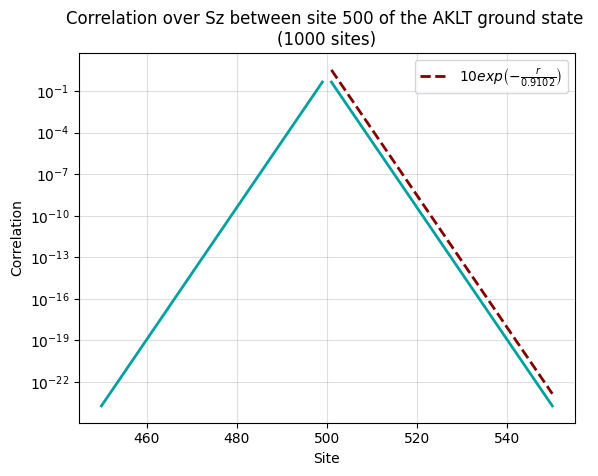

In [17]:
reach = 50
start = L//2
corrsR = []
for i in range(reach):
    corr = obj.get_corr(site1=start, site2=i+1+start)
    corrsR.append(corr)

corrsL = []
for i in range(reach):
    corr = obj.get_corr(site1=start, site2=-i-1+start)
    corrsL.append(corr)


sites_r = np.arange(reach) + start + 1
rs = sites_r - start


def exp_decay(r, A, xi):
    return A * np.exp(-r / (xi))



exp = 1/np.log(3)
a = 10

plt.plot(sites_r, corrsR, lw = 2, color = '#00A0A0')
plt.plot(sites_r[::-1] - reach - 1, corrsL, lw = 2, color = '#00A0A0')
plt.plot(sites_r, exp_decay(sites_r-start, a, exp), lw = 2, alpha = 1, color = '#800000', ls = "--", label = rf'${a} exp\left(-\frac{{r}}{{{exp :.4f}}}\right)$')
plt.title(f'Correlation over Sz between site {start} of the AKLT ground state \n({L} sites)')
plt.yscale('log')
plt.xlabel('Site')
plt.ylabel('Correlation')
plt.grid(alpha=0.4)
plt.legend()
plt.show()




slope:  -0.9102392258369442


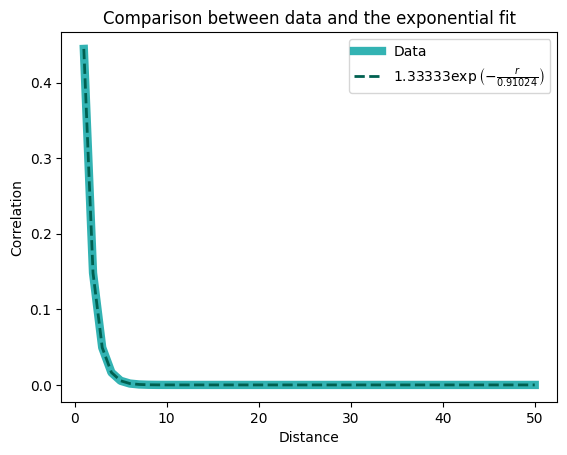

In [18]:
slope, intercept, r_value, p_value, std_err = stats.linregress(rs, np.log(corrsR))
print("slope: ", 1/slope)

popt, _ = curve_fit(exp_decay, rs, corrsR)
A_fit, xi_fit = popt
plt.plot(rs, corrsR, lw = 6, alpha = .8, color = '#00A0A0', label = 'Data')
plt.plot(rs, exp_decay(rs, A_fit, xi_fit), label = rf"${A_fit :1g}\exp\left(-\frac{{r}}{{{xi_fit :.5g}}}\right)$" , lw = 2, alpha = 1., color = '#006050', ls = "--")
plt.xlabel('Distance')
plt.ylabel('Correlation')
plt.title('Comparison between data and the exponential fit')
plt.legend()
plt.show()

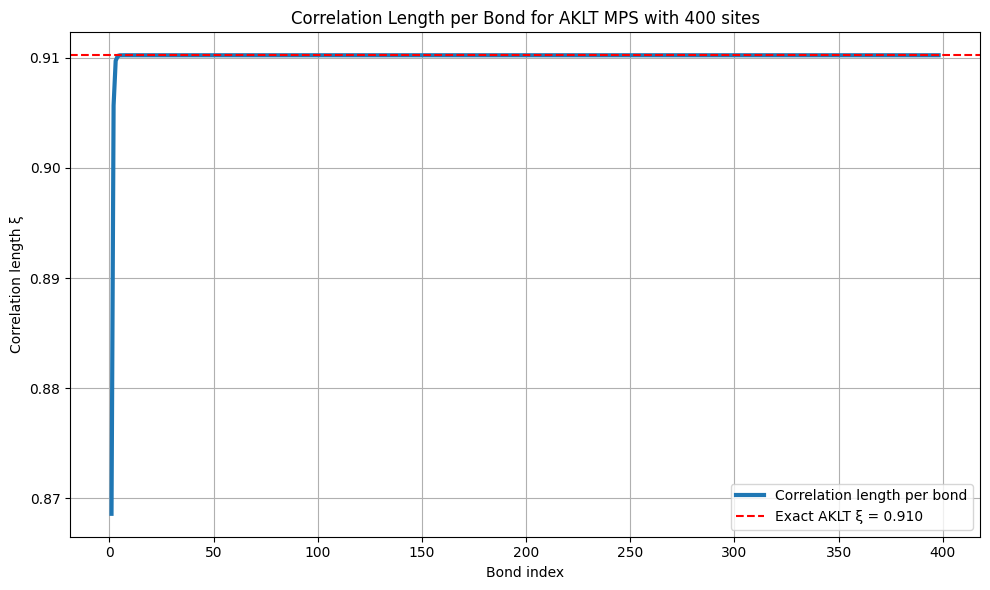

In [304]:
first_eigen, second_eigen, correlation_lengths= obj.full_chain_correlation_length()

xi_exact = 1 / np.log(3)
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(correlation_lengths)+1), correlation_lengths, label='Correlation length per bond', linewidth=3)
plt.axhline(y=xi_exact, color='r', linestyle='--', label=f'Exact AKLT ξ = {xi_exact:.3f}')
plt.xlabel('Bond index')
plt.ylabel('Correlation length ξ')
plt.title(f'Correlation Length per Bond for AKLT MPS with {L} sites')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

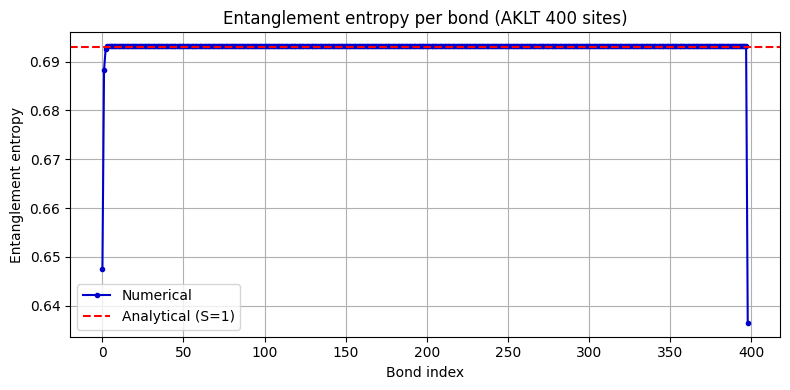

In [301]:
entropies = obj.all_bond_entropies()
bond_indices = np.arange(len(entropies))

plt.figure(figsize=(8, 4))
plt.plot(bond_indices, entropies, marker='.', linestyle='-', color='mediumblue', label='Numerical')
plt.axhline(y=0.693, color='red', linestyle='--', label='Analytical (S=1)')
plt.xlabel("Bond index")
plt.ylabel("Entanglement entropy")
plt.title(f"Entanglement entropy per bond (AKLT {L} sites)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Converged at step 75 with energy -665.9999999999969 and standard deviation  1.83e-13


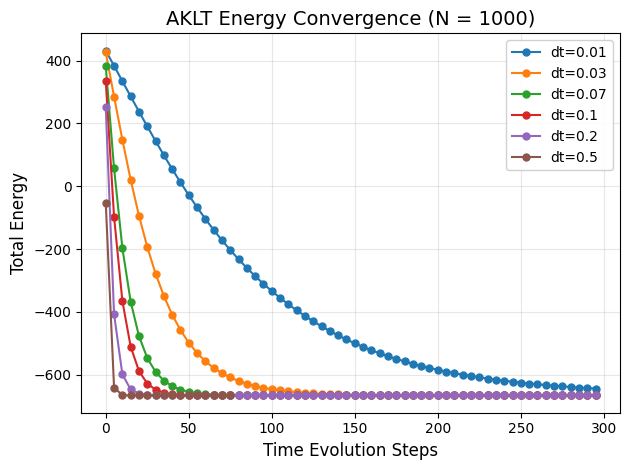

In [6]:
# List of time step values to test
dts = [0.01, 0.03, 0.07, 0.1, 0.2, 0.5]
# List of system sizes (currently only testing N=1000)
Ns = [1000]

# Loop over different system sizes
for N in Ns:
    # Loop over different time steps
    for t in dts:
        # Initialize MPS for current parameters:
        obj = TNet(N = N, spin = 1, chi = 2, max_bond_dim=2)
        
        # Perform time evolution while tracking energy convergence:
        data = obj.evolve_convergence(dt= t,  steps=300, imaginary=True, dyn_bond=True, make_canonical_every=1)
        
        # Unpack the convergence data:
        steps_recorded, energies = data
        
        # Plot energy convergence for this dt value:
        plt.plot(steps_recorded, energies, 'o-', 
                 markersize=5, linewidth=1.5,
                 label=f'dt={t}')
    
    # Plot formatting and labels
    plt.xlabel('Time Evolution Steps', fontsize=12)  # X-axis label
    plt.ylabel('Total Energy', fontsize=12)         # Y-axis label
    plt.title(f'AKLT Energy Convergence (N = {N})', fontsize=14)  # Plot title with current N
    plt.legend(fontsize=10, framealpha=0.9)         # Configure legend appearance
    plt.grid(True, alpha=0.3)                       # Add semi-transparent grid
    
    # Adjust layout to prevent label clipping
    plt.tight_layout()
    # Display the plot
    plt.show()

Converged at step 390 with energy -1.9999999999999996 and standard deviation  1.80e-15
Finished TEBD for L=4, chi_max=4 in 0.13 seconds
Converged at step 385 with energy -1.9999999999999998 and standard deviation  1.48e-15
Finished TEBD for L=4, chi_max=9 in 0.13 seconds
Converged at step 340 with energy -2.0000000000000004 and standard deviation  1.49e-15
Finished TEBD for L=4, chi_max=24 in 0.12 seconds
Converged at step 360 with energy -1.9999999999999996 and standard deviation  9.52e-16
Finished TEBD for L=4, chi_max=60 in 0.15 seconds
Converged at step 340 with energy -1.999999999999999 and standard deviation  1.24e-15
Finished TEBD for L=4, chi_max=150 in 0.15 seconds
Converged at step 450 with energy -5.333333333333328 and standard deviation  5.22e-15
Finished TEBD for L=9, chi_max=4 in 0.38 seconds
Converged at step 460 with energy -5.333333333333333 and standard deviation  4.63e-15
Finished TEBD for L=9, chi_max=9 in 0.37 seconds
Converged at step 445 with energy -5.3333333333

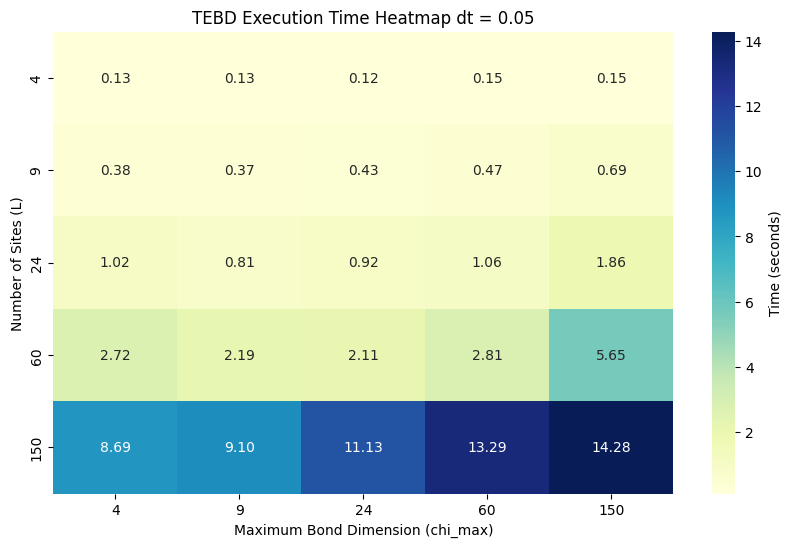

8.881784197001252e-16 is the higest error for the ground state energy. seems to be nothing more than a rounding error.


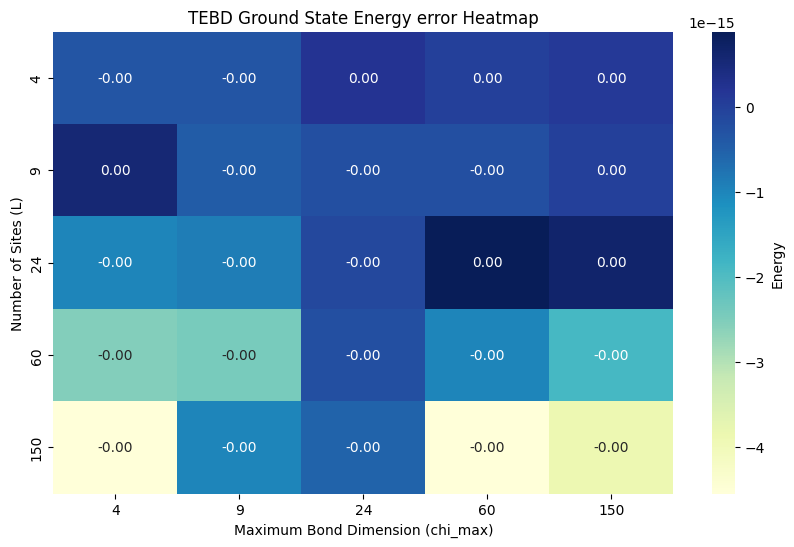

In [3]:
Llist = np.logspace(np.log10(4), np.log10(150), 5, dtype=int)
CHIlist = np.logspace(np.log10(4), np.log10(150), 5, dtype=int)
Times = np.zeros((len(Llist), len(CHIlist)))
Energies = np.zeros((len(Llist), len(CHIlist)))


for i in range(len(Llist)):
    for j in range(len(CHIlist)):
        L = Llist[i]
        chi = CHIlist[j]
        obj = TNet(N = L, spin = 1, chi = chi, max_bond_dim=chi)
        
        try:
            start = time.time()
            obj.evolve_convergence(dt=0.05, steps=2000, imaginary=True, dyn_bond=True, make_canonical_every=1)
            end = time.time()
            E0 = obj.total_energy()
            E0 /= (L-1)
            E0 += 2/3
        except Exception as e:
            print(f"Error for L={L}, chi_max={chi}: {e}")
            E0 = np.nan
            start = 0.
            end = 0.

        print(f"Finished TEBD for L={L}, chi_max={chi} in {end - start:.2f} seconds")


        Times[i, j] = end - start
        Energies[i, j] = E0


plt.figure(figsize=(10, 6))
sns.heatmap(Times, annot=True, fmt=".2f", cmap="YlGnBu",
            xticklabels=CHIlist, yticklabels=Llist,
            cbar_kws={'label': 'Time (seconds)'})
plt.title('TEBD Execution Time Heatmap dt = 0.05')
plt.xlabel('Maximum Bond Dimension (chi_max)')
plt.ylabel('Number of Sites (L)')
plt.show()

print(f"{np.max(Energies)} is the higest error for the ground state energy. seems to be nothing more than a rounding error.")
plt.figure(figsize=(10, 6))
sns.heatmap(Energies, annot=True, fmt=".2f", cmap="YlGnBu",
            xticklabels=CHIlist, yticklabels=Llist,
            cbar_kws={'label': 'Energy'})
plt.title('TEBD Ground State Energy error Heatmap')
plt.xlabel('Maximum Bond Dimension (chi_max)')
plt.ylabel('Number of Sites (L)')
plt.show()


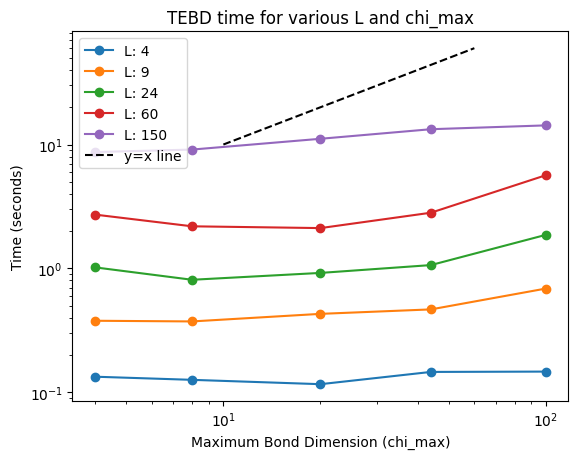

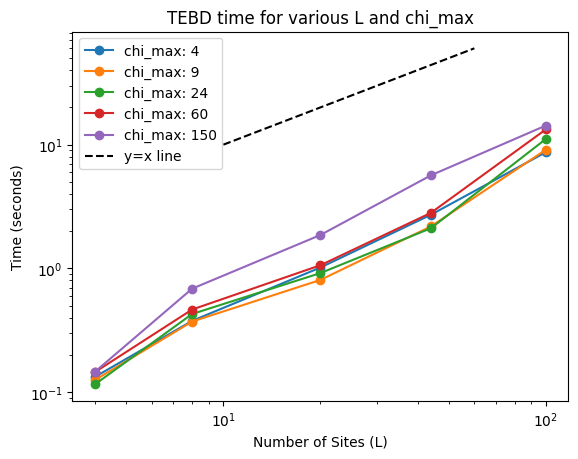

In [4]:
for i in range(len(Times)):
    row = Times[i]
    row[row == 0] = np.nan

    plt.loglog(np.logspace(np.log10(4), np.log10(100), 5, dtype=int), row, label=f"L: {CHIlist[i]}", marker = "o")

plt.ylabel("Time (seconds)")
plt.xlabel("Maximum Bond Dimension (chi_max)")
plt.plot(np.arange(10,100,50), np.arange(10,100,50), ls = "--", color = "black", label = "y=x line")
plt.title("TEBD time for various L and chi_max")
plt.legend()
plt.show()


for i in range(len(Times)):
    col = Times[:,i]
    col[col == 0] = np.nan

    plt.loglog(np.logspace(np.log10(4), np.log10(100), 5, dtype=int), col, label=f"chi_max: {Llist[i]}", marker = "o")

plt.ylabel("Time (seconds)")
plt.xlabel("Number of Sites (L)")
plt.plot(np.arange(10,100,50), np.arange(10,100,50), ls = "--", color = "black", label = "y=x line")
plt.title("TEBD time for various L and chi_max")
plt.legend()
plt.show()